# Importing Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/lewagon/Yassine_AI_resume/resume_cleaned.csv')


In [ ]:
df.head()

,resume,category
0,skills programming languages python pandas num...,Technology and IT
1,education details x d may to may b e uit rgpv ...,Technology and IT
2,areas of interest deep learning control system...,Technology and IT
3,skills r python sap hana tableau sap hana sql ...,Technology and IT
4,education details x d mca ymcaust faridabad ha...,Technology and IT


In [ ]:
df['resume'] = df['resume'].astype(str)
df['lenght']=df['resume'].apply(lambda x: len(x.split()))

In [ ]:
df['lenght'].mean()

774.6714285714286

<Axes: xlabel='lenght', ylabel='Count'>

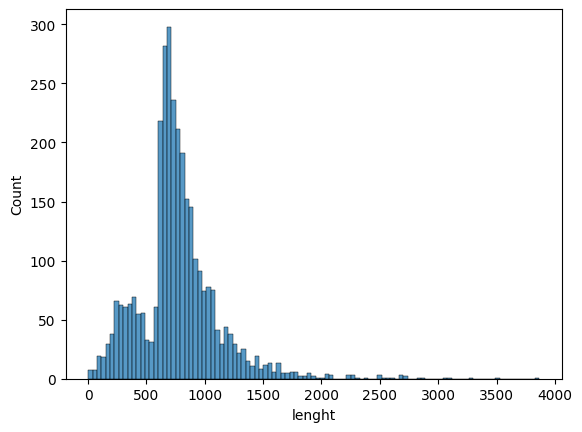

In [ ]:
sns.histplot(df['lenght'])

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Charger la liste des mots communs en anglais
stop_words = set(stopwords.words('english'))

# Supprimer les stopwords
def data_clean_nltk(x):
    tokens = word_tokenize(x)
    tokens_filtered = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens_filtered)

#supprimer les doublons et les lettres uniques
def data_clean(x):
    words = x.split()
    words_filtered = [word for word in words if len(word) > 2 and word]
    unique_sorted_list = sorted(set(words_filtered))
    return ' '.join(unique_sorted_list)

#supprime les mots dont le sens est identique
lemmatizer = WordNetLemmatizer()
def lemmatize_text(x):
    tokens = word_tokenize(x)
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens_lemmatized)


df['resume_cleaned'] = df['resume']
df['resume_cleaned'] = df['resume_cleaned'].apply(data_clean_nltk)
df['resume_cleaned'] = df['resume_cleaned'].apply(data_clean)
df['resume_cleaned'] = df['resume_cleaned'].apply(lemmatize_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['lenght_cleaned']=df['resume_cleaned'].apply(lambda x: len(x.split()))
df['lenght_cleaned'].mean()

306.88291925465836

In [ ]:
num_categories= len(df['category'].value_counts())
num_categories

15

# Training the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Attention


# Division en deux set d'entraînement et de test sur tout le dataset
X=df['resume_cleaned']
y=df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert labels to integers
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

In [ ]:
# Tokenizer to convert text into sequences of integers
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

from tensorflow.keras.layers import BatchNormalization

#Padding to ensure all sequences have the same length
max_len = 5000
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_seq, padding='post', maxlen=max_len)

In [ ]:
from keras.regularizers import l2


model_0 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_len,mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(len(y.unique()), activation='softmax')
])

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Définition du modèle CNN
model_1 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    # Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(len(y.unique()), activation='softmax')
])


In [ ]:

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Définition du modèle RNN
model_2 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len),
    SimpleRNN(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(y.unique()), activation='softmax')

])

## TROP LONG !

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Définition du modèle CNN
model_3 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len),
    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.01)),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(y.unique()), activation='softmax')
])

#BEST MODEL :0.84. MODEL SAVED

In [ ]:
from keras.regularizers import l2

model_4 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len),
    Conv1D(32, 5, activation='relu', kernel_regularizer=l2(0.02)),  # Augmentation de la valeur de régularisation
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.02)),  # Augmentation de la valeur de régularisation
    Dropout(0.5),
    Dense(len(y.unique()), activation='softmax')
])


In [ ]:
model=model_4

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
epochs=100

model.fit(X_padded, y_labels, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])  # modifier le nombre d'epoch

# Evaluate the model on the entire dataset
test_loss, test_acc = model.evaluate(X_padded, y_labels)
print("Accuracy on the entire dataset:", test_acc)

Epoch 1/100
81/81 [==============================] - 12s 125ms/step - loss: 3.8601 - accuracy: 0.1300 - val_loss: 3.7138 - val_accuracy: 0.2655
Epoch 2/100
81/81 [==============================] - 44s 552ms/step - loss: 3.1949 - accuracy: 0.2597 - val_loss: 3.4154 - val_accuracy: 0.3339
Epoch 3/100
24/81 [=======>......................] - ETA: 4:40 - loss: 2.8262 - accuracy: 0.3581

In [ ]:
import joblib

# Sauvegarder le modèle dans Google Drive
joblib.dump(model, '/content/drive/MyDrive/lewagon/Yassine_AI_resume/nn_model.pkl')


['/content/drive/MyDrive/lewagon/Yassine_AI_resume/nn_model.pkl']